# Assigment 5 - Embeddings

The goal of this assignment is to train a Word2Vec skip-gram model over Text8 data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

/Users/gautamsharma/anaconda/envs/tf-env-test/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    # Collect most common 49999 words along with their frequencies of occurance.
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # Dictionary with word (as index of dict) along with corresponding index in 'count' list.
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    # Get count of rare words. Here "rare" means words which are not amongst most common 49999 words.
    # 'data' list contains index of each word (in 'words' list) in 'count' list.
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    # Add count of rare words to 'count' list.
    count[0][1] = unk_count
    # Get reverse of dictionary.
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

# Build dataset.
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [8]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    # Sanity check: Raise exception is result is false.
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    # Data batch.
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    # collections.deque creates data structure which can perform memory efficient appends and pops
    buffer = collections.deque(maxlen=span)
    # Append indices (index of each word (of 'words' list) in 'count' list) of data.
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data) # Roll back to zeroth index if reached at end of list.
    # Look at output of this snippet to interpret working of this loop.
    # skip_window: specifies window i.e it indicates how many words to consider for random picking.
    # num_skips: How many times to reuse an input to generate a label.
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data) # Roll back to zeroth index if reached at end of list.
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2), (4, 3)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'term', 'anarchism', 'originated', 'term', 'as', 'originated', 'of']

with num_skips = 4 and skip_window = 3:
    batch: ['a', 'a', 'a', 'a', 'term', 'term', 'term', 'term']
    labels: ['abuse', 'anarchism', 'of', 'as', 'first', 'originated', 'of', 'abuse']


Train a skip-gram model.

In [9]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size)) # Generate <valid_size> random numbers 
                                                                          # in range(valid_window) i.e between 0-99
# Read about negative sampling in word2vec.pdf
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                                                 stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                                             train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # NOTE: The code snippet below may seem complex at first but if you read the comments
    # and do the math i.e try matrix multiplies (which consists of multiple dot products of vectors in matrix)
    # you will be able to easily understand the code snippet below.
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm # Normalization is done in order to obtain cosine by simply taking 
                                              # dot products (which are included in matrix multiplication)
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    # To compare how similar the word vectors (of dimension 128) in the validation set, 
    # i.e. valid_embeddings, are to these 50000 vectors, a doc product is used be2cause 
    # the formula for cosine distance tells us so. 
    # Essentially, we take each 128-long vector in the validation set 
    # and compare it with each 128-long vector in the vocabulary.
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [10]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.024385
Nearest to three: naughton, spanish, execution, rashad, landes, taliaferro, octal, nationalities,
Nearest to his: crooked, distrust, reason, alain, ugric, pritchard, workforce, mb,
Nearest to were: abiword, pairwise, pows, chakras, heavenly, totaling, bloemfontein, iona,
Nearest to often: sexy, lina, lana, psycho, centro, avenue, roundhouse, neburg,
Nearest to in: fughetta, compound, finalised, pharos, impeach, architecturally, croat, manner,
Nearest to other: gregorian, gatherer, eider, disenchanted, jacky, bid, bookstore, reflex,
Nearest to by: immanent, conquerors, taira, qaddafi, mercury, mosfet, synapse, existentialists,
Nearest to use: slid, refraining, hitchcock, tren, idiots, nelson, canso, requisite,
Nearest to for: overtly, awarding, autographs, bomis, crocodile, leaks, ramifications, anglo,
Nearest to is: unnatural, mancha, demonstrable, architects, transforms, vijayanagara, anschluss, nymph,
Nearest to seven: minya, unclaimed, ho

Visualize embedding space in lower dimensions.

In [11]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

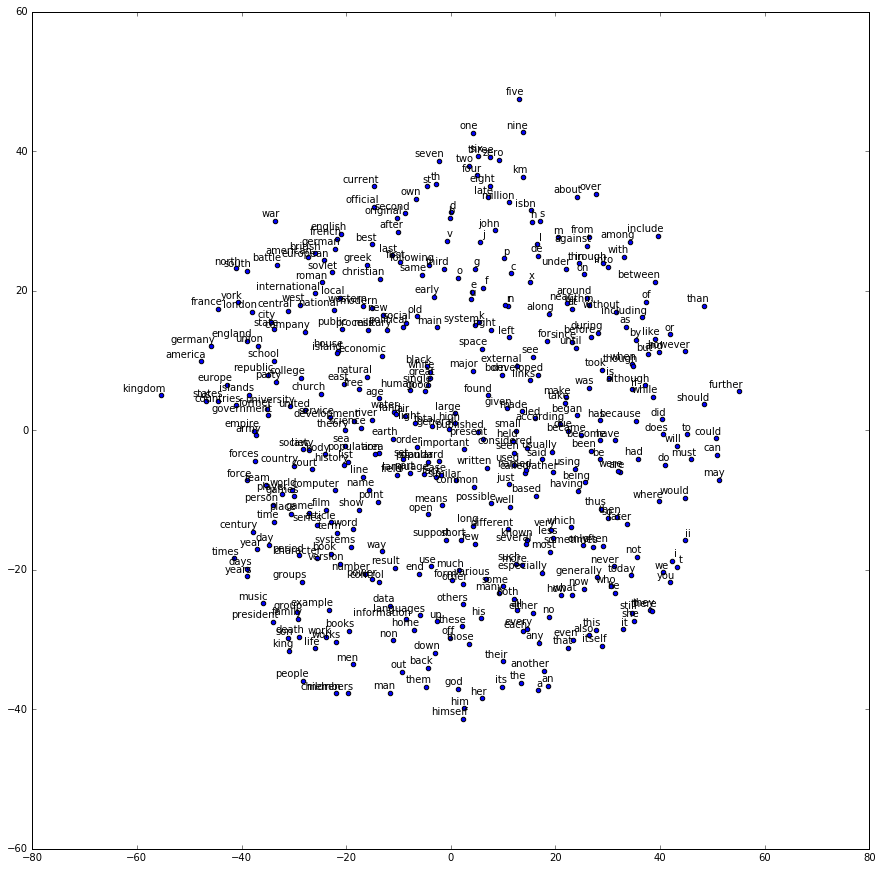

In [12]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## Problem 

An alternative to skip-gram is another Word2Vec model called CBOW (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

In [24]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
words_in_context = 3 # For validation set, pick 3 words for context as input to our CBOW model.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 * words_in_context # Random set of words to evaluate similarity on. 
                                   # Multiplied by words_in_context to get 48 words which would be 
                                   # reduced to 16 contexts by taking average of 3 successive words.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples_allwords = np.array(random.sample(range(valid_window), valid_size)) # Generate valid_size random numbers 
                                                                          # in range(valid_window) i.e between 0-99.
                                                                          # This is done to randomly pick examples.
# Read about negative sampling in word2vec.pdf
num_sampled = 64 # Number of negative examples to sample.

# Method for selecting input context (context length is 3 words):
# Select valid_size random numbers with range(valid_window).
# Average up 3 successive word's indices in the set so as to obtain the context of 3 words together.
# Eg: If context is x1,x2,x3 where each is a 1-hot word vector then input to our model should be (x1+x2+x3)/3
valid_examples_context = [np.sum(valid_examples_allwords[i*words_in_context : i*words_in_context+words_in_context])/words_in_context for i in range((valid_size / words_in_context))]    


graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset_allwords = tf.constant(valid_examples_allwords, dtype=tf.int32)
    valid_dataset = tf.constant(valid_examples_context, dtype=tf.int32)
    
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                                                 stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                                             train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # NOTE: The code snippet below may seem complex at first but if you read the comments
    # and do the math i.e try matrix multiplies (which consists of multiple dot products of vectors in matrix)
    # you will be able to easily understand the code snippet below.
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm # Normalization is done in order to obtain cosine by simply taking 
                                              # dot products (which are included in matrix multiplication)
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    # To compare how similar the word vectors (of dimension 128) in the validation set, 
    # i.e. valid_embeddings, are to these 50000 vectors, a doc product is used because 
    # the formula for cosine distance tells us so. 
    # Essentially, we take each 128-long vector in the validation set 
    # and compare it with each 128-long vector in the vocabulary.
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [25]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size / words_in_context):
                valid_context = [reverse_dictionary[valid_examples_allwords[i*words_in_context + j]] for j in range(words_in_context)]
                top_k = 1 # number of nearest neighbors (Pick only 1 nearest neighbour)
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_context
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.702135
Nearest to ['most', 'also', 'war']: arcades,
Nearest to ['on', 's', 'this']: literals,
Nearest to ['by', 'and', 'use']: lysergic,
Nearest to ['used', 'five', 'about']: gardnerian,
Nearest to ['their', 'no', 'had']: rufinus,
Nearest to ['not', 'american', 'with']: search,
Nearest to ['four', 'as', 'six']: invertebrate,
Nearest to ['called', 'been', 'a']: notes,
Nearest to ['be', 'when', 'that']: ottoman,
Nearest to ['or', 'system', 'may']: irma,
Nearest to ['only', 'was', 'it']: lysergic,
Nearest to ['states', 'many', 'between']: mirc,
Nearest to ['nine', 'can', 'has']: annul,
Nearest to ['some', 'who', 'for']: sha,
Nearest to ['d', 'in', 'world']: odrade,
Nearest to ['than', 'more', 'there']: gig,
Average loss at step 2000: 4.338876
Average loss at step 4000: 3.859439
Average loss at step 6000: 3.736626
Average loss at step 8000: 3.727139
Average loss at step 10000: 3.640695
Nearest to ['most', 'also', 'war']: he,
Nearest to ['on', 's', 'thi